# Evaluate Contest Results

In [1]:
%run "C:\Users\james\Documents\MLB\Code\U1. Imports.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U2. Utilities.ipynb"
%run "C:\Users\james\Documents\MLB\Code\U3. Classes.ipynb"

baseball_path = r'C:\Users\james\Documents\MLB\Database'

### Payouts

This assigns payouts to entry results.

In [42]:
# Assign payouts to existing contest lineups
def add_payouts(contestKey):
    # Read in DraftKings actual contest entries
    entry_scores = pd.read_csv(os.path.join(baseball_path, "A01. DraftKings", "5. Entry Results", f"Entry Results {contestKey}.csv"), encoding='iso-8859-1')
    entry_scores['Rank'] = entry_scores['Rank'].astype('int')

    # Read in Payouts
    payouts = pd.read_csv(os.path.join(baseball_path, "A01. DraftKings", "3. Payouts", f"Payouts {contestKey}.csv"), encoding='iso-8859-1')

    # Convert payouts to numeric
    payouts['payoutDescription'] = payouts['payoutDescription'].str.replace(',', '').str.replace('$', '').astype(float)
    
    # Rename 
    payouts.rename(columns={'minPosition':'Lower', 'maxPosition':'Upper', 'payoutDescription':'Payout'}, inplace=True)
    
    # Keep relevant variables
    payouts = payouts[['Lower', 'Upper', 'Payout']]
    
    
    # Loop over column rows
    for i, row in entry_scores.iterrows():
        rank = row['Rank']
        mask = (payouts['Lower'] <= rank) & (rank <= payouts['Upper'])
        if mask.any():
            payout = payouts.loc[mask, 'Payout'].values[0]
        else:
            payout = 0
        # Assign payout if Rank in range [Lower, Upper]
        entry_scores.at[i, 'Payout'] = payout

    return entry_scores

In [43]:
# entry_scores = add_payouts(146482590)

### Evaluate My Lineups

In [54]:
# Read in lineup sims and assign points
def calculate_lineup_returns(contestKey):
    # Read in Contest Guide
    guide = pd.read_csv(os.path.join(baseball_path, "A09. Contest Guides", f"Contest Guide {contestKey}.csv"))
                                   
    # Extract entry fee    
    entryFee = guide['entryFee'][0]
    
    # Read in lineup sims
    sims = pd.read_csv(os.path.join(baseball_path, "B03. Lineups", "3. Lineups Ranked", f"Lineups Ranked {contestKey}.csv"), encoding='iso-8859-1')
    
    # Read in players and opponent lineups
    entry_scores = add_payouts(contestKey)

    # Read in player scores
    player_scores = pd.read_csv(os.path.join(baseball_path, "A01. DraftKings", "6. Player Results", f"Player Results {contestKey}.csv"), usecols=['Player', 'FPTS'], encoding='iso-8859-1')
    
    
    # For each position, merge the player's point total
    points_list = []
    for pos in ['P', 'P.1', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF.1', 'OF.2']:
        # Merges on name only, remove numeric characters
        sims[pos] = sims[pos].str.replace(r'[(0-9)]', "", regex=True)
        sims[pos] = sims[pos].str.rstrip()
        
        # Merge with points
        sims = sims.merge(player_scores, left_on=pos, right_on='Player', how='left')
        points_name = 'FPTS' + "_" + pos
        points_list.append(points_name)
        sims.drop(columns={'Player'},inplace=True)
        sims.rename(columns={'FPTS':points_name},inplace=True)
        
        # # Identify missing scores (these might not be usable, could be worth investigating)
        # print(pos, sims[f'FPTS_{pos}'].isna().sum())
    
    # May duplicate if multiple players have the same name, usually want the first
    sims.drop_duplicates(subset=['P', 'P.1', 'C', '1B', '2B', '3B', 'SS', 'OF', 'OF.1', 'OF.2'], keep='first', inplace=True)
    sims.reset_index(inplace=True, drop=True)

    # Calculate lineup points
    sims['Points'] = sims[points_list].sum(axis=1)
    
    sims['Rank'] = np.nan
    sims['Payout'] = np.nan
    for index, row in sims.iterrows():
        points = row['Points']
        match = entry_scores[entry_scores['Points'] < points].iloc[0]
        sims.at[index, 'Rank'] = match['Rank']
        sims.at[index, 'Payout'] = match['Payout']

    # Convert to numeric
    sims['Payout'] = sims['Payout'].astype('float')
    
    # Rate of Return
    sims['Return'] = (sims['Payout'] / entryFee) - 1
    
    # Add contestKey
    sims['contestKey'] = contestKey
    
    return sims

In [55]:
def calculate_lineup_returns2(contestKey):
    try:
        return calculate_lineup_returns(contestKey)
    except:
        pass

In [56]:
# sims = calculate_lineup_returns("145091030")

,P,P.1,C,1B,2B,3B,SS,OF,OF.1,OF.2,Budget,AvgPointsPerGame,Sim 0,Sim 1,Sim 2,Sim 3,Sim 4,Sim 5,Sim 6,Sim 7,Sim 8,Sim 9,Sim 10,Sim 11,Sim 12,Sim 13,Sim 14,Sim 15,Sim 16,Sim 17,Sim 18,Sim 19,Sim 20,Sim 21,Sim 22,Sim 23,Sim 24,Sim 25,Sim 26,Sim 27,Sim 28,Sim 29,Sim 30,Sim 31,Sim 32,Sim 33,Sim 34,Sim 35,Sim 36,Sim 37,Sim 38,Sim 39,Sim 40,Sim 41,Sim 42,Sim 43,Sim 44,Sim 45,Sim 46,Sim 47,Sim 48,Sim 49,Sim 50,Sim 51,Sim 52,Sim 53,Sim 54,Sim 55,Sim 56,Sim 57,Sim 58,Sim 59,Sim 60,Sim 61,Sim 62,Sim 63,Sim 64,Sim 65,Sim 66,Sim 67,Sim 68,Sim 69,Sim 70,Sim 71,Sim 72,Sim 73,Sim 74,Sim 75,Sim 76,Sim 77,Sim 78,Sim 79,Sim 80,Sim 81,Sim 82,Sim 83,Sim 84,Sim 85,Sim 86,Sim 87,Sim 88,Sim 89,Sim 90,Sim 91,Sim 92,Sim 93,Sim 94,Sim 95,Name,P_rostership,P.1_rostership,C_rostership,1B_rostership,2B_rostership,3B_rostership,SS_rostership,OF_rostership,OF.1_rostership,OF.2_rostership,P50,P75,P90,P95,P99,P100,Tail,Sim STD,Plus2,Plus3,rostership,pitcher rostership,batter rostership,FPTS_P,FPTS_P.1,FPTS_C,FPTS_1B,FPTS_2B,FPTS_3B,FPTS_SS,FPTS_OF,FPTS_OF.1,FPTS_OF.2,Points,Rank,Payout,Return,contestKey
0,Taj Bradley,J.P. France,Salvador Perez,Vinnie Pasquantino,Michael Massey,Ryan McMahon,Bobby Witt Jr.,MJ Melendez,Corbin Carroll,Pavin Smith,49600.0,102.883,147.15,89.6,130.15,124.7,115.0,84.95,118.5,97.2,46.35,64.35,52.05,73.85,184.0,143.15,150.45,85.85,119.8,124.35,80.1,60.25,117.1,58.3,59.0,58.6,142.7,55.15,94.85,85.45,98.8,108.1,154.1,117.6,104.0,165.4,91.0,129.5,75.4,62.65,114.75,104.9,172.85,61.15,73.2,68.0,100.65,98.8,93.0,117.2,98.55,59.0,83.2,110.05,98.45,117.75,152.15,133.45,61.2,88.6,105.55,102.5,20.9,146.25,139.4,198.7,130.65,79.0,103.75,200.05,68.65,111.4,110.1,91.75,120.0,95.05,113.15,130.4,54.35,121.95,81.95,97.5,84.5,79.2,138.1,87.15,137.25,105.85,103.0,77.65,97.4,112.6,57.8,120.4,76.85,124.95,95.8,78.9,Pavin Smith,28.08,5.0,5.17,4.29,3.9,4.48,5.0,4.48,15.58,7.36,99.725,120.7875,144.7,156.925,198.7675,200.05,921.0,33.67025,170.2235,203.893749,83.34,33.08,50.26,26.35,15.5,5.0,15.0,23.0,32.0,21.0,18.0,6.0,20.0,181.85,16.0,200.0,49.0,145091030


### Evaluate 

In [7]:
# Create list of contestKeys with available guides
contestKey_list = os.listdir(os.path.join(baseball_path, "A09. Contest Guides"))
contestKey_list = [int(key.replace(".csv", "").split(" ")[2]) for key in contestKey_list]

# Create list of contestKeys with available results
result_contestKey_list = os.listdir(os.path.join(baseball_path, "A01. DraftKings", "6. Player Results"))
result_contestKey_list = [int(key.replace(".csv", "").split(" ")[2]) for key in result_contestKey_list]

# Find the overlap 
available_contestKey_list = list(set(result_contestKey_list) & set(contestKey_list))

In [8]:
# %%time
# sims_list = Parallel(n_jobs=-1, verbose=1)(delayed(calculate_lineup_returns2)(contestKey) for contestKey in available_contestKey_list[55:])

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   32.5s


CPU times: total: 3.16 s
Wall time: 1min 13s


[Parallel(n_jobs=-1)]: Done 352 out of 352 | elapsed:  1.2min finished


In [9]:
# all_sims_df = pd.concat(sims_list, axis=0)
# all_sims_df.describe()

,Budget,AvgPointsPerGame,Sim 0,Sim 1,Sim 2,Sim 3,Sim 4,Sim 5,Sim 6,Sim 7,Sim 8,Sim 9,Sim 10,Sim 11,Sim 12,Sim 13,Sim 14,Sim 15,Sim 16,Sim 17,Sim 18,Sim 19,Sim 20,Sim 21,Sim 22,Sim 23,Sim 24,Sim 25,Sim 26,Sim 27,Sim 28,Sim 29,Sim 30,Sim 31,Sim 32,Sim 33,Sim 34,Sim 35,Sim 36,Sim 37,Sim 38,Sim 39,Sim 40,Sim 41,Sim 42,Sim 43,Sim 44,Sim 45,Sim 46,Sim 47,Sim 48,Sim 49,Sim 50,Sim 51,Sim 52,Sim 53,Sim 54,Sim 55,Sim 56,Sim 57,Sim 58,Sim 59,Sim 60,Sim 61,Sim 62,Sim 63,Sim 64,Sim 65,Sim 66,Sim 67,Sim 68,Sim 69,Sim 70,Sim 71,Sim 72,Sim 73,Sim 74,Sim 75,Sim 76,Sim 77,Sim 78,Sim 79,Sim 80,Sim 81,Sim 82,Sim 83,Sim 84,Sim 85,Sim 86,Sim 87,Sim 88,Sim 89,Sim 90,Sim 91,Sim 92,Sim 93,Sim 94,Sim 95,P_rostership,P.1_rostership,C_rostership,1B_rostership,2B_rostership,3B_rostership,SS_rostership,OF_rostership,OF.1_rostership,OF.2_rostership,P50,P75,P90,P95,P99,P100,Tail,Sim STD,Plus2,Plus3,rostership,pitcher rostership,batter rostership,FPTS_P,FPTS_P.1,FPTS_C,FPTS_1B,FPTS_2B,FPTS_3B,FPTS_SS,FPTS_OF,FPTS_OF.1,FPTS_OF.2,Points,Rank,Payout,Return,contestKey
count,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.00000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64450.000000,64378.000000,63858.000000,64059.000000,64299.000000,64084.000000,63912.000000,64154.000000,64387.000000,64136.000000,63894.000000,64450.000000,64450.000000,64450.000000,64450.000000,6.445000e+04
mean,49560.878200,102.788611,103.827971,104.511892,101.236739,103.443109,104.694131,104.117241,104.286418,102.440804,105.631453,102.158078,104.123351,102.952301,102.802189,101.461420,103.654517,101.229058,100.377891,101.479887,104.349920,102.224320,102.099142,104.556098,104.219424,103.754425,102.295645,101.234650,100.620614,102.476418,104.600442,101.65804,103.527268,103.390863,102.490700,105.113497,103.259901,103.732849,104.695187,101.216690,101.708078,103.441023,103.581119,104.527953,102.410289,103.500535,102.719738,103.082873,100.177732,102.824141,102.338635,100.575729,99.678724,102.997866,102.803564,101.814486,101.708896,102.434300,101.081816,102.108235,101.916061,103.087379,102.283292,100.969515,103.591552,103.747731,103.267086,102.950233,101.637564,105.692059,103.484428,102.289380,102.202054,101.653078,101.679647,106.019957,103.285794,102.465393,103.319382,101.398252,104.710352,102.752606,102.512515,102.237070,103.102161,101.464863,100.398462,101.524615,104.415250,102.102301,101.618275,102.151681,103.434031,100.703481,105.270546,106.440410,104.484240,99.983590,26.385522,25.238564,7.278101,7.426606,7.854916,10.074460,10.630813,8.857568,8.980998,9.466573,101

In [10]:
# all_sims_df2 = all_sims_df.dropna()
# all_sims_df2.describe()

,Budget,AvgPointsPerGame,Sim 0,Sim 1,Sim 2,Sim 3,Sim 4,Sim 5,Sim 6,Sim 7,Sim 8,Sim 9,Sim 10,Sim 11,Sim 12,Sim 13,Sim 14,Sim 15,Sim 16,Sim 17,Sim 18,Sim 19,Sim 20,Sim 21,Sim 22,Sim 23,Sim 24,Sim 25,Sim 26,Sim 27,Sim 28,Sim 29,Sim 30,Sim 31,Sim 32,Sim 33,Sim 34,Sim 35,Sim 36,Sim 37,Sim 38,Sim 39,Sim 40,Sim 41,Sim 42,Sim 43,Sim 44,Sim 45,Sim 46,Sim 47,Sim 48,Sim 49,Sim 50,Sim 51,Sim 52,Sim 53,Sim 54,Sim 55,Sim 56,Sim 57,Sim 58,Sim 59,Sim 60,Sim 61,Sim 62,Sim 63,Sim 64,Sim 65,Sim 66,Sim 67,Sim 68,Sim 69,Sim 70,Sim 71,Sim 72,Sim 73,Sim 74,Sim 75,Sim 76,Sim 77,Sim 78,Sim 79,Sim 80,Sim 81,Sim 82,Sim 83,Sim 84,Sim 85,Sim 86,Sim 87,Sim 88,Sim 89,Sim 90,Sim 91,Sim 92,Sim 93,Sim 94,Sim 95,P_rostership,P.1_rostership,C_rostership,1B_rostership,2B_rostership,3B_rostership,SS_rostership,OF_rostership,OF.1_rostership,OF.2_rostership,P50,P75,P90,P95,P99,P100,Tail,Sim STD,Plus2,Plus3,rostership,pitcher rostership,batter rostership,FPTS_P,FPTS_P.1,FPTS_C,FPTS_1B,FPTS_2B,FPTS_3B,FPTS_SS,FPTS_OF,FPTS_OF.1,FPTS_OF.2,Points,Rank,Payout,Return,contestKey
count,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.00000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,62440.000000,6.244000e+04
mean,49560.504484,102.702444,103.891159,104.450923,101.349054,102.969914,104.575742,104.211638,104.297075,102.809769,105.538334,102.203307,104.045158,102.990314,102.909135,101.418382,103.537734,101.420339,100.398225,101.694885,104.144911,102.140576,102.286079,104.383920,104.180209,103.844657,102.236361,101.000209,100.446590,102.407455,104.724032,101.740007,103.286469,103.480730,102.300694,104.823786,103.430062,103.923799,104.736927,101.284431,101.569122,103.500763,103.482729,104.310748,101.900082,103.359777,102.723221,102.666504,99.574865,102.993735,102.109832,100.463487,99.723115,103.165052,102.858606,102.028467,101.287096,102.180730,101.013177,101.666820,101.859340,102.981388,102.430620,101.289041,103.755409,103.494478,103.289078,102.648143,101.523169,105.317143,103.039995,102.206280,101.965812,101.514644,101.277275,105.935215,102.958991,102.215854,103.312868,101.192127,105.057071,102.589288,102.548844,102.017368,103.494793,101.343941,100.252289,101.487437,104.556573,102.138495,101.393434,101.61197,103.024679,100.307535,104.996489,106.053652,104.602743,99.660181,26.158788,25.604741,7.288765,7.466755,7.854238,10.138756,10.689317,8.899722,9.044099,9.509316,101.

### Evaluate Metrics
Metrics: <br>
AvgPointsPerGame: Average projection
Sim STD: Standard deviation of all lineup projections
Plus#: AvgPointsPerGame + # * Sim STD
Tail: Sum of projections from 95th-100th percentile

In [11]:
def add_metrics(payout_df):
    # We want reverse ranks for ownership stats
    payout_df['Rarity'] = payout_df['rostership'] * -1 
    payout_df['Batter'] = payout_df['batter rostership'] * -1 
    payout_df['Pitcher'] = payout_df['pitcher rostership'] * -1 

    # Calculate rank
    for metric in ['AvgPointsPerGame', 'Sim STD', 'Plus2', 'Plus3', 'Tail', 'Rarity', 'Batter', 'Pitcher']:
        print(metric)
        payout_df.sort_values(['contestKey', metric], ascending=False, inplace=True)
        payout_df[f'{metric} Rank'] = payout_df.groupby('contestKey').cumcount() + 1

    # Add together rarity and tail ranks
    payout_df['Choose'] = payout_df['Rarity Rank'] + payout_df['Tail Rank']
    payout_df['Choose2'] = payout_df['Batter Rank'] + payout_df['Tail Rank']

    for metric in ['Choose', 'Choose2']:
        print(metric)
        payout_df.sort_values(['contestKey', metric], ascending=True, inplace=True)
        payout_df[f'{metric} Rank'] = payout_df.groupby('contestKey').cumcount() + 1
        
    return payout_df

In [12]:
# all_sims_df2 = add_metrics(all_sims_df2)
# all_sims_df2.head(1)

AvgPointsPerGame
Sim STD
Plus2
Plus3
Tail
Rarity
Batter
Pitcher
Choose
Choose2


,P,P.1,C,1B,2B,3B,SS,OF,OF.1,OF.2,Budget,AvgPointsPerGame,Sim 0,Sim 1,Sim 2,Sim 3,Sim 4,Sim 5,Sim 6,Sim 7,Sim 8,Sim 9,Sim 10,Sim 11,Sim 12,Sim 13,Sim 14,Sim 15,Sim 16,Sim 17,Sim 18,Sim 19,Sim 20,Sim 21,Sim 22,Sim 23,Sim 24,Sim 25,Sim 26,Sim 27,Sim 28,Sim 29,Sim 30,Sim 31,Sim 32,Sim 33,Sim 34,Sim 35,Sim 36,Sim 37,Sim 38,Sim 39,Sim 40,Sim 41,Sim 42,Sim 43,Sim 44,Sim 45,Sim 46,Sim 47,Sim 48,Sim 49,Sim 50,Sim 51,Sim 52,Sim 53,Sim 54,Sim 55,Sim 56,Sim 57,Sim 58,Sim 59,Sim 60,Sim 61,Sim 62,Sim 63,Sim 64,Sim 65,Sim 66,Sim 67,Sim 68,Sim 69,Sim 70,Sim 71,Sim 72,Sim 73,Sim 74,Sim 75,Sim 76,Sim 77,Sim 78,Sim 79,Sim 80,Sim 81,Sim 82,Sim 83,Sim 84,Sim 85,Sim 86,Sim 87,Sim 88,Sim 89,Sim 90,Sim 91,Sim 92,Sim 93,Sim 94,Sim 95,Name,P_rostership,P.1_rostership,C_rostership,1B_rostership,2B_rostership,3B_rostership,SS_rostership,OF_rostership,OF.1_rostership,OF.2_rostership,P50,P75,P90,P95,P99,P100,Tail,Sim STD,Plus2,Plus3,rostership,pitcher rostership,batter rostership,FPTS_P,FPTS_P.1,FPTS_C,FPTS_1B,FPTS_2B,FPTS_3B,FPTS_SS,FPTS_OF,FPTS_OF.1,FPTS_OF.2,Points,Rank,Payout,Return,contestKey,Rarity,Batter,Pitcher,AvgPointsPerGame Rank,Sim STD Rank,Plus2 Rank,Plus3 Rank,Tail Rank,Rarity Rank,Batter Rank,Pitcher Rank,Choose,Choose2,Choose Rank,Choose2 Rank
5,Shane Bieber,Shohei Ohtani,Austin Nola,Luke Voit,Jake Cronenworth,Manny Machado,Francisco Lindor,Juan Soto,Starling Marte,Trent Grisham,49600.0,100.828,53.0,121.85,139.45,82.25,95.2,68.85,73.45,70.15,55.6,115.1,94.7,98.4,127.4,96.85,90.65,136.25,42.45,47.5,76.7,107.0,98.6,69.35,91.5,111.4,83.05,111.0,119.55,100.25,164.35,69.4,93.45,73.65,106.85,61.05,112.3,96.8,118.9,150.5,121.4,109.7,121.35,92.05,110.05,86.45,71.85,125.2,131.6,112.4,104.85,137.85,129.25,114.3,91.1,65.3,72.85,134.15,25.05,85.5,95.2,100.3,122.35,51.05,117.65,226.0,110.85,109.6,118.2,98.45,120.1,130.75,78.2,104.6,115.5,95.3,98.65,106.25,110.4,110.6,51.2,95.8,95.25,70.2,98.55,98.9,50.25,74.5,101.05,133.1,132.75,60.2,180.0,53.55,148.5,125.1,138.6,85.0,Trent Grisham,0.86,0.74,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,99.575,119.0625,133.625,141.7125,182.3,226.0,869.35,31.025842,162.879684,193.905527,1.6,1.6,0.0,14.7,23.5,5.0,6.0,4.0,2.0,5.0,16.0,5.0,3.0,84.2,13729.0,0.0,-1.0,125294388,-1.6,-0.0,-1.6,26,5,5,6,8,1,1,20,9,9,1,1


In [13]:
def evaluate_metric(payout_df, metric, lineups=10):   
    # Sort by metric
    payout_df.sort_values(metric, ascending=True, inplace=True)
    # Select the top n lineup 
    group = payout_df.groupby('contestKey')['Return'].head(lineups)

    # Calculate average profit
    profit = group.mean()

    return profit

### Main Result
If I enter my typical 5 lineups per night, which approach is the most profitable?

In [57]:
# metrics = ['AvgPointsPerGame', 'Sim STD', 'Plus2', 'Plus3', 'Tail', 'Rarity', 'Batter', 'Pitcher', 'Choose', 'Choose2']
# lineups = 20
# for metric in metrics:
#     # print(metric)
#     profit = evaluate_metric(all_sims_df2, metric, lineups)
#     print("With the {} metric, the top {} lineups would average a profit of {:.2f}.".format(metric, lineups, profit))

With the AvgPointsPerGame metric, the top 20 lineups would average a profit of -0.08.
With the Sim STD metric, the top 20 lineups would average a profit of -0.04.
With the Plus2 metric, the top 20 lineups would average a profit of -0.04.
With the Plus3 metric, the top 20 lineups would average a profit of -0.04.
With the Tail metric, the top 20 lineups would average a profit of -0.09.
With the Rarity metric, the top 20 lineups would average a profit of -0.11.
With the Batter metric, the top 20 lineups would average a profit of -0.13.
With the Pitcher metric, the top 20 lineups would average a profit of -0.06.
With the Choose metric, the top 20 lineups would average a profit of 0.13.
With the Choose2 metric, the top 20 lineups would average a profit of 0.13.


### Regression

In [28]:
# import statsmodels.api as sm
# # Step 1: Choose variables
# X = all_sims_df2[['Tail Rank', 'Rarity Rank']]
# y = all_sims_df2['Return']

# # Step 2: Add a constant term to the input features
# X = sm.add_constant(X)

# # Step 3: Create and fit the OLS model
# model = sm.OLS(y, X)
# results = model.fit()

# # Step 4: Print the summary
# results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Return   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.942
Date:                Fri, 16 Feb 2024   Prob (F-statistic):              0.143
Time:                        19:30:23   Log-Likelihood:            -2.3304e+05
No. Observations:               62440   AIC:                         4.661e+05
Df Residuals:                   62437   BIC:                         4.661e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.2498      0.106      2.364      0.018       0.043       0.457
Tail Rank      -0.0008      0.001     -1.109      0.268      -0.002       0.001
Rarity Rank    -0.0011      0.001     -1.606      0.108      -0.003       0.000
==============================================================================
Omnibus:                   220019.285   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.000   Jarque-Bera (JB):     109233135338.865
Skew:                          69.424   Prob(JB):                         0.00
Kurtosis:                    6481.160   Cond. No.                         398.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Conclusion: worse ranked lineups do perform worse, on average, but it's not statistically significant. <br>
Expected payout for any additional lineups is below $4, so adding lineups isn't necessarily wise, at this moment.

### Plot

In [58]:
def plot_payouts(payout_df, metric):
    # Take average by rank
    df = payout_df.groupby([f'{metric} Rank'])['Return'].mean().reset_index()

    # Graph it
    plt.scatter(df[f'{metric} Rank'], df['Return'])

    # Fit line
    coefficients = np.polyfit(df[f'{metric} Rank'], df['Return'], 1)
    p = np.poly1d(coefficients)
    plt.plot(df[f'{metric} Rank'], p(df[f'{metric} Rank']), color='red', label='Trend line')

    # Labels and title
    plt.xlabel(f'{metric} Rank')
    plt.ylabel('Return')
    plt.title('Scatter Plot of Rank vs Return')

    # Display trend line equation
    equation = f'Return = {coefficients[0]:.2f} * Rank + {coefficients[1]:.2f}'
    plt.text(0.5, 0.9, equation, ha='center', va='center', transform=plt.gca().transAxes)

    # Legend and show plot
    plt.legend()
    plt.show()

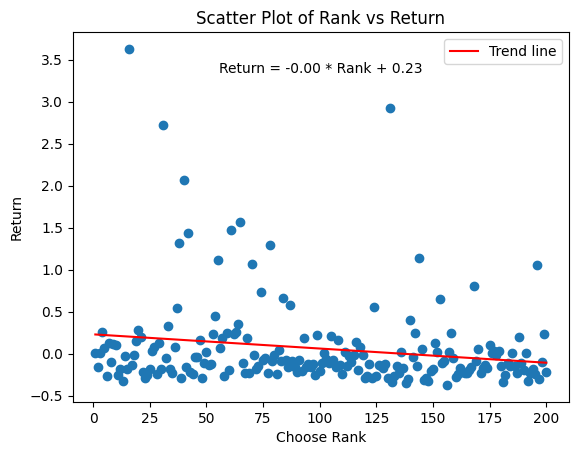

In [59]:
# plot_payouts(all_sims_df2, "Choose")

In [115]:
from paretoset import paretoset
import pandas as pd

In [376]:
# all_sims_df2['pareto'] = paretoset(all_sims_df2[["AvgPointsPerGame", "Sim STD", 'batter rostership', 'contestKey']], sense=['max', 'max', 'min', 'diff']).astype('int')

In [382]:
def pareto_ttest(df):
    # Perform t-test
    t_stat, p_value_t = ttest_ind(df[df['pareto'] == 0]['Return'],
                                   df[df['pareto'] == 1]['Return'])

    # Perform Mann-Whitney U test (non-parametric test for non-normally distributed data)
    u_stat, p_value_u = mannwhitneyu(all_sims_df2[all_sims_df2['pareto'] == 0]['Return'],
                                     all_sims_df2[all_sims_df2['pareto'] == 1]['Return'])

    print("T-test p-value:", p_value_t)
    print("Mann-Whitney U test p-value:", p_value_u)


T-test p-value: 0.229935770933437
Mann-Whitney U test p-value: 0.10511303868392147
